In this notebook we will attempt to learn how to construct and train a deep neural network from scratch to predict the handwritten digits. For this task we will perform the following:
- download and check the data
- prepare the dataset for training
- train the baseline model
- process to develop a better model
- analyze results

First, we import all the libraries we need:

In [1]:
#!pip install -Uqq fastai

In [2]:
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 17.5 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import SubsetRandomSampler

# fastai
from fastai.vision.all import *
from fastbook import *

Nest, we define global variables and plot style:

In [4]:
# Plotting style
plt.style.use('ggplot')

# Global variables
DATA_DIR = Path('/kaggle/working/data/')

# About the dataset

## Download the dataset

To train anything we first need the data. For this project we will use the famous [MNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) comprised of images of digits from 0 to 9 where our task is to predict the digit based on the image provided. The dataset is already provided in the `dataset` module of `torchvision` library. To view which datasets are available see the [link](https://pytorch.org/vision/stable/datasets.html).

To download the dataset we need to provide the following arguments: `root`: where to save the downloaded files, `train`: should the train dataset be downloaded, and `download` whether to download the dataset. Note that if the data already exists locally in the provided `root` argument then the data will not be downloaded. The dataset will be processed as PyTorch `DataSet`.

In [5]:
# Train set
data_train = datasets.MNIST(root=DATA_DIR, train=True, download=True,
                            transform=ToTensor())
# Test set
data_test = datasets.MNIST(root=DATA_DIR, train=False, download=True,
                           transform=ToTensor())

print(f'Train data: {len(data_train)}')
print(f'Test data: {len(data_test)}')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw

Train data: 60000
Test data: 10000


- `root`: file directory into which the data is downloaded
- `train`: should the training data set be downloaded
- `download`: should we download the data. If the data already exists in the `root` it will not be downloaded
- `transform = ToTensor()`: "Convert a PIL Image or ndarray to tensor and scale the values accordingly." ([Ref.](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor)) Note that the transform will be applied to the PIL image when we access it via the `DataLoader`. Also we can explicitly call `ToTensor()` to transform the PIL image.

Let's check the size of the datasets:

In [6]:
print(f'Train: {data_train.data.shape}')
print(f'Test: {data_test.data.shape}')

Train: torch.Size([60000, 28, 28])
Test: torch.Size([10000, 28, 28])


So in total there are 70000 images of handrwitten digits, where each is of size 28 by 28 pixels. Since the data is processed as PyTorch dataset then we know that each element of `data_train` is a tuple of inputs and labels as we can see if we take the first element:

In [7]:
# Get the first image and it corresponding label
data_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

Let's see visualize some of the images look like:

In [8]:
def show_sample(data):
    """Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html"""
    fig = plt.figure(figsize=(7,7))
    cols, rows = 3,3
    for i in range(1, cols*rows+1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        # Get image and the corresponding label
        img, label = data[sample_idx]
        fig.add_subplot(rows,cols,i)
        plt.imshow(img, cmap='Blues')
        plt.title(f'Label: {label}', size=10)
        plt.axis("off")
    plt.show()

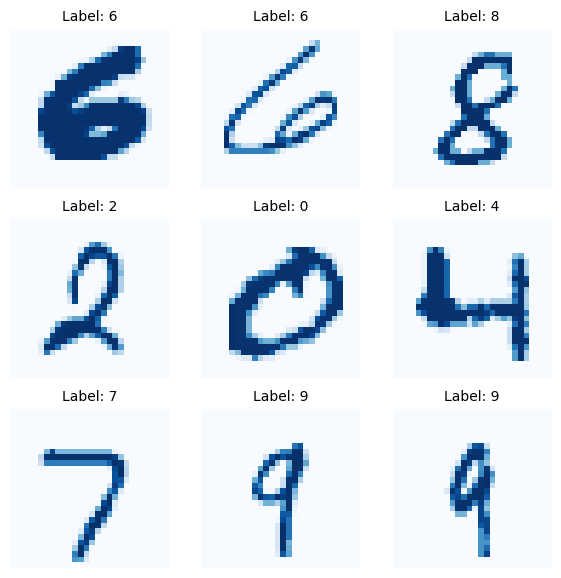

In [9]:
show_sample(data_train)

Each of the images is composed of pixels ranging from 0 to 255, where 0 represents white and 255 black. Let's see what we mean by that:

In [10]:
# Extract the first image and its label from the dataset
img, label = data_train[0]
print(f'Image dimension: {img.shape}')
print(f'Label: {label}')

Image dimension: (28, 28)
Label: 5


So the image size is 28 by 28 pixels and the first image should represent digit 5. Let's see the pixel data, which we will convert to tensors first. Then for better representation, we wrap the data with the dataframe and style it using the blue gradient. From the image below we can see that it does look like digit 5.

In [11]:
dfimg = pd.DataFrame(tensor(img))
dfimg.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


## Prepare dataset for training

Previously we have downloaded two datasets, training and testing. To be able to deduce whether our model is overfitting during training we need another dataset, namely, validation set. The validation set will show us how our model performs on out-of-sample data, i.e. data that have not been used in training.

We will generate the validation dataset from the training dataset since it is much bigger than the given test set, naturally.

For this problem, we can assume that the images in the dataset are independent and don't have any underlying structure, like time, we should think about when splitting the dataset. The only aspect we should worry about is the distribution of digits in all samples. Ideally, we want the digits to be distributed in the same way in all samples, so when creating the dataset for validation we should keep this in mind. For example, if we would have a training set of a very small number of say digits 3 but a large sample of digits 3 in the test set then the model has a very limited information scope to learn from, but it is expected to know 3s very well in out-of-sample settings.

So first, let's check the distributions of labels in our datasets. We can use `class_to_idx` to get the dictionary of labels in our dataset.

In [12]:
# Get mapping of target IDs
print(data_train.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [13]:
# Define custom colors for the labels
import matplotlib.colors as mcolors

colors = ["#D9D2D8","#F2BBC9", "#BF849A", "#8C7A89", "#9AC7D9", 
          "#82C0D9", "#7DABB3", "#8F9FBF", "#737F99", "#566073"]
cmap = mcolors.ListedColormap(colors)

Plot the distributions of labels for training and test sets:

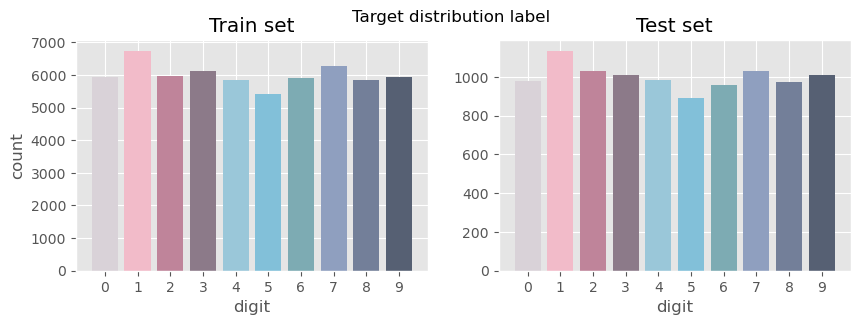

In [14]:
df = pd.DataFrame(pd.Series(data_train.targets).value_counts().reset_index())
df.columns = ['digit', 'count']
df.sort_values('digit', inplace=True)
dft = pd.DataFrame(pd.Series(data_test.targets).value_counts().reset_index())
dft.columns = ['digit', 'count']
dft.sort_values('digit', inplace=True)
fig,_=plt.subplots(1,2, figsize=(10,3))
plt.suptitle('Target distribution label')
plt.subplot(1,2,1)
plt.bar('digit', 'count',data=df, color=cmap(df.digit))
plt.title('Train set')
plt.xlabel('digit')
plt.xticks(range(len(df.digit)), df.digit)
plt.ylabel('count')
plt.subplot(1,2,2)
plt.bar('digit', 'count',data=dft, color=cmap(dft.digit))
plt.title('Test set')
plt.xlabel('digit')
plt.xticks(range(len(dft.digit)), dft.digit)
plt.show()

We can see from the above figures that the target distributions for both training and test sets are similar and all digits are represented relatively in a balanced structure, which means we can just split the training data randomly into training and validation sets. Note that if the sample is not balanced then when splitting the sample we should preserve the sample imblance.

We will use `SubsetRandomSampler` to select the data. The `SubsetRandomSampler` uses indices from the original dataset to select subsets of data. So, first we need to define which indices are for the training sample and which are to be used for the validation sample. The steps are:

[Ref](https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a)

In [15]:
# Step 1 - Length of train dataset from which we are splitting the data
Nd = len(data_train); print(f'Dataset length: {Nd}')

# Step 2 - Create a shuffled list of training indices
Nd_idx = list(range(Nd))
np.random.shuffle(Nd_idx)
print(f'Shuffled indices {Nd_idx[:5]}')

# Step 3 - Define percentage of indices for the training sample
# to compute number of indices to be included in the training sample
train_pct = 0.7
Nt = int(np.floor(train_pct * Nd))

# Step 4 - Split the indices into training and validation
# and pass the indices to the SubsetRandomSampler
tr_idx, vl_idx = Nd_idx[:Nt], Nd_idx[Nt:]

# SubsetRandomSampler(indices): Samples elements randomly from a given list of indices, without replacement.
tr_sampler = SubsetRandomSampler(tr_idx)
vl_sampler = SubsetRandomSampler(vl_idx)

print(f'\nTrain idx length: {len(tr_sampler)}')
print(L(tr_sampler)[:5])
print(f'\nValid idx length: {len(vl_sampler)}')
print(L(vl_sampler)[:5])

Dataset length: 60000
Shuffled indices [12628, 37730, 39991, 8525, 8279]

Train idx length: 42000
[57386, 9188, 12487, 4528, 22234]

Valid idx length: 18000
[38187, 32955, 9866, 43333, 46707]


Now, that we have the samplers for training and validation, we can create the objects for each dataset which will contain all the information used in the training process with respect to the input data.

In order to train the model using PyTorch there are two basic requirements in regards to the input data:
1. the dataset has to be in the form of a tuple with the structure (input, label) where each is a tensor
2. the input data should be stored in batches, i.e. the input data is iterable over batches.

Note that the initial data is already in form of tuples, as we saw previously. To create the iterable batches we will use a PyTorch object called `DataLoader` which takes a Python collection and converts it to an iterator based on batches. From the PyTorch documentation we have:

> Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset. [Ref]()

Since we have a dataset and samplers for each subset we can create dataloaders for each sample:

In [16]:
# Define number of mini-batches
no_batches = 64

Let's check what we have got in training and validation dataloaders. We also need to check whether there are any partial batches, i.e. leftover samples when constructing mini-batches. Note that there is an option in `DataLoader` called `drop_last` to drop any such letfovers.

In [17]:
def check_batches(sampler, batch_size):
    
    # Number of samples to expect in the final dataloader
    no_samples = len(sampler)
    
    # Number of batches to expect in the final dataloader
    no_batches = int(np.ceil(no_samples / batch_size))
    print(f'Number of batches total: {no_batches}')
    
    # Samples in the last batch (leftover samples)
    lb_samples = no_samples % batch_size
    
    if lb_samples != 0:
        no_batches -= 1
    
    print(f'Full batches: {no_batches}')
    if lb_samples != 0:
        print(f'Samples in partial batch: {lb_samples}')
    
    return no_batches, lb_samples

Let's check for training and validation sample:

In [18]:
print('Training sample')
tr_batches, tr_lb_samples = check_batches(tr_sampler, no_batches)
print('\nValidation sample')
vl_batches, vl_lb_samples = check_batches(vl_sampler, no_batches)

Training sample
Number of batches total: 657
Full batches: 656
Samples in partial batch: 16

Validation sample
Number of batches total: 282
Full batches: 281
Samples in partial batch: 16


Note that we can not use `shuffle=True` when using `SubsetRandomSampler()`. 

In [19]:
# Training dataloader
dl_train = torch.utils.data.DataLoader(data_train, batch_size=no_batches, shuffle=False, sampler=tr_sampler)

# Validation dataloader
dl_valid = torch.utils.data.DataLoader(data_train, batch_size=no_batches, shuffle=False, sampler=vl_sampler)

# Test dataloader
dl_test = torch.utils.data.DataLoader(data_test, batch_size=no_batches, shuffle=True)

To check the size of the dataloader we can use `len()` which will give us the number of batches created for each dataset.

In [20]:
print(f'Training batches: {len(dl_train)}')
print(f'Validation batches: {len(dl_valid)}')
print(f'Test batches: {len(dl_test)}')

Training batches: 657
Validation batches: 282
Test batches: 157


The numbers for the batches from the dataloaders align with what we have calculated from the samplers.

# Training

## Define the device for training

We can train our model either on CPU or GPU whichever is available. To see what is available on the current computer we can run the following command:

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device!')

Using cpu device!
